In [1]:
library(gdata)
library(zoo)

getshiller <- function(source="http://www.econ.yale.edu/~shiller/data/ie_data.xls",cachefile="shiller.RData") {
  
  if (file.exists(cachefile)) {
    load(cachefile)
    return(x)
  }
  xraw <- read.xls(source, sheet = "Data", verbose=FALSE, perl="perl")
  xraw[xraw=="#N/A"]  <- NA
  rawrows    <- dim(xraw)[1]
  rawcols    <- 14
  xraw <- xraw[,-14]
  t.x  <- as.Date(sprintf("%4.2f.01",as.numeric(as.vector(xraw[,1]))),"%Y.%m.%d")
  ok   <- !is.na(t.x)
  x    <- zoo(as.numeric(as.vector(xraw[ok,2])),t.x[ok])
  for ( i in seq(3,rawcols) ) {
    z    <- zoo(as.numeric(as.vector(xraw[ok,i])),t.x[ok])
    x    <- merge.zoo(x,z)
  }
  colnames(x) <- c("P","D","E","CPI","DateFraction","LongRate","P.real","D.real","P.realtr","E.real","E.realtr","CAPE","CAPE.tr")
  save(x,file=cachefile)
  return(x)
}

gdata: read.xls support for 'XLS' (Excel 97-2004) files ENABLED.



gdata: read.xls support for 'XLSX' (Excel 2007+) files ENABLED.


Attaching package: ‘gdata’


The following object is masked from ‘package:stats’:

    nobs


The following object is masked from ‘package:utils’:

    object.size


The following object is masked from ‘package:base’:

    startsWith



Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




In [2]:
library(ggplot2)
z <- getshiller()
# autoplot(z)

# autoplot(z) + theme_bw()
tail(fortify(z))
#ggplot(fortify(z,melt=TRUE)) + geom_line(aes(x=Index,y=Value)) + theme_bw()

,Index,P,D,E,CPI,DateFraction,LongRate,P.real,D.real,P.realtr,E.real,E.realtr,CAPE,CAPE.tr
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1797,2020-09-01,3365.52,58.85,98.22,260.28,2020.71,0.68,3370.40,58.94,NA,98.36,NA,30.83,33.81
1798,2020-10-01,3418.70,58.66,NA,260.39,2020.79,0.79,3422.24,58.72,NA,NA,NA,31.28,34.30
1799,2020-11-01,3548.99,58.47,NA,260.23,2020.87,0.87,3554.84,58.57,NA,NA,NA,32.44,35.60
1800,2020-12-01,3695.31,58.28,NA,260.47,2020.96,0.93,3697.92,58.32,NA,NA,NA,33.69,37.00
1801,2021-01-01,3793.75,NA,NA,260.60,2021.04,1.08,3794.64,NA,NA,NA,NA,34.52,37.88
1802,2021-02-01,3826.31,NA,NA,260.66,2021.12,1.09,3826.31,NA,NA,NA,NA,34.77,38.12


# Inflation matters

[1] "Most recent entry =  2021-02-01"
[1] "Total time span in years =  150.083504449008"


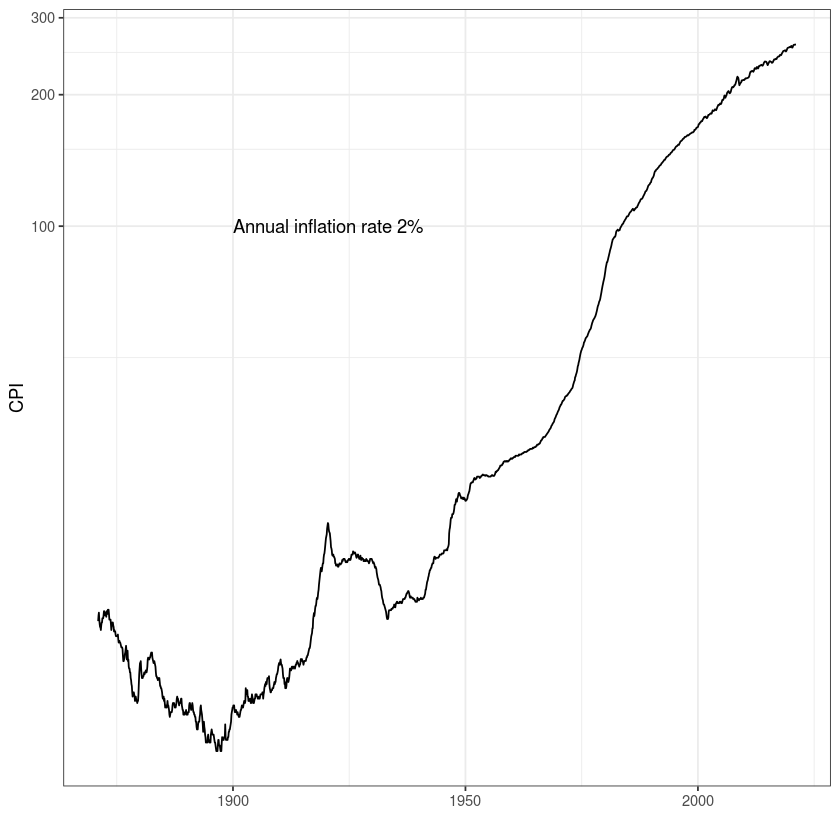

In [3]:
library(zoo)
library(ggplot2)
shiller <- getshiller()
cpi <- as.matrix(shiller$CPI)
print(paste("Most recent entry = ", end(shiller)), quotes ="none")
time.span.years <- as.numeric(end(shiller) - start(shiller)) / 365.25
print(paste("Total time span in years = ", time.span.years))
cpi.rate <- 100 * ((cpi[nrow(cpi)] / cpi[1]) ^ (1 / time.span.years) - 1)

label <- paste("Annual inflation rate ",round(cpi.rate,1),"%",sep="")
autoplot(shiller[,"CPI"]) +
  coord_trans(y="log") +
  xlab("") + ylab("CPI") +
  annotate(geom="text",x=as.Date("1900-01-01"),y=100,label=label,hjust=0) +
  theme_bw()

`geom_smooth()` using formula 'y ~ x'



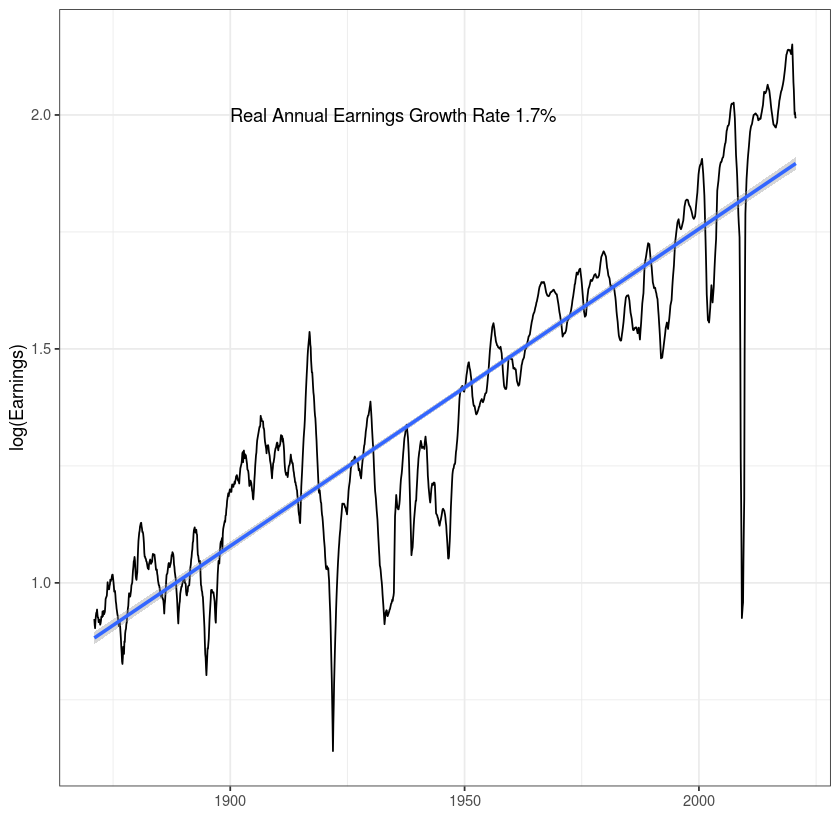

In [4]:
eps.zoo <- shiller$E.real # holds the real earnings,after inflation?
eps.zoo <- eps.zoo[!is.na(eps.zoo)]
eps <- as.matrix(eps.zoo)
time.span.years <- as.numeric(end(eps.zoo) - start(eps.zoo)) / 365.25
eps.rate <- 100 * ((eps[nrow(eps)] / eps[1]) ^ (1 / time.span.years) - 1)
label <- paste("Real Annual Earnings Growth Rate ",round(eps.rate,1),"%",sep="")
df <- fortify(eps.zoo,melt=TRUE)
ggplot(df) +
  geom_line(aes(x=Index,y=log10(Value),group=Series)) +
  xlab("") + ylab("log(Earnings)") +
  stat_smooth(aes(x=Index,y=log10(Value)),method=lm,fullrange=TRUE) +
  annotate(geom="text",x=as.Date("1900-01-01"),y=2,label=label,hjust=0) +
  theme_bw()

# Share prices track earnings over the long-term

> The average CAPE over the last 140 years is about 16.5. While the S&P 500 price does stray a long way from the average you can be sure that it returns to the average eventually. Statisticians would call this mean reversion. Investors would call this a gift because it tells you when shares are expensive and cheap.

> If the CAPE is above its long-term average this means share prices are over-valued, and vice versa. Unfortunately, shares can be expensive or cheap for a very long time so the timing of this signal is almost useless. If you would have sold your shares when CAPE is two standard deviations above its long-term average (CAPE greater than 30) you would have sold in June 1997 at 876.29. The S&P 500 didn’t peak until two years later in August 2000 at 1485.46. You would have been kicking yourself as shares rallied another 70% while you stood in the sidelines, and the ensuing crash would have been small comfort.

Warning message:
“Removed 120 row(s) containing missing values (geom_path).”


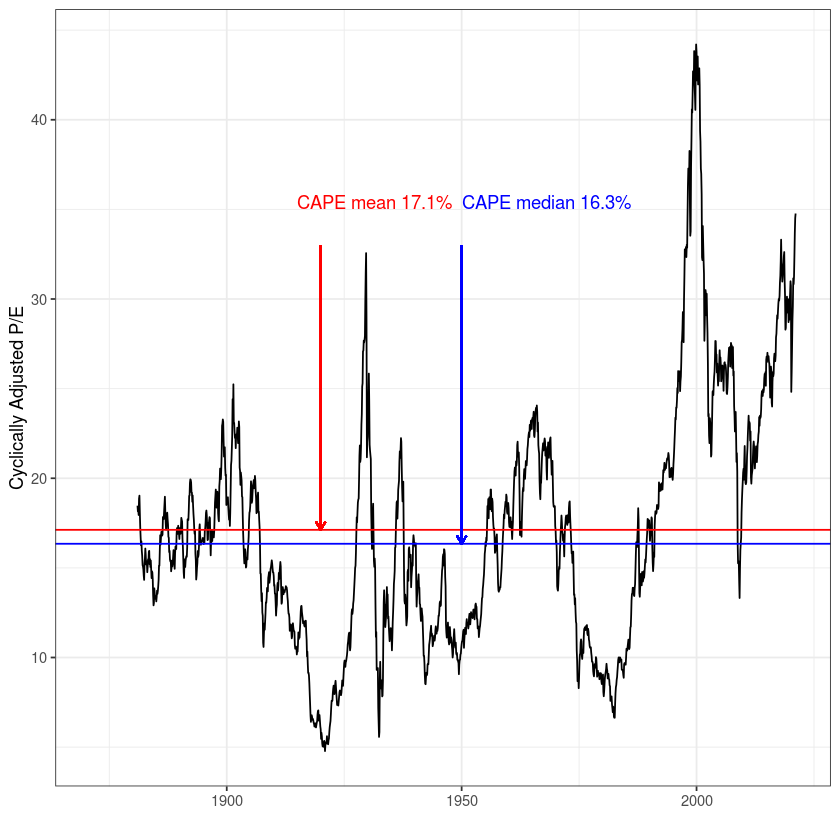

In [5]:
library(grid) # for arrow()
shiller.mean <- mean(shiller$CAPE,na.rm=TRUE)
shiller.median <- median(shiller$CAPE,na.rm=TRUE)
labelmean <- paste("CAPE mean ",round(shiller.mean,1),"%",sep="")
labelmedian <- paste("CAPE median ",round(shiller.median,1),"%",sep="")
autoplot(shiller$CAPE) +
  geom_abline(intercept=shiller.mean,slope=0,col="red") +
  geom_abline(intercept=shiller.median,slope=0,col="blue") +
  xlab("") + ylab("Cyclically Adjusted P/E") +
  geom_segment(aes(x=as.Date("1920-01-01")
                   ,xend=as.Date("1920-01-01")
                   ,y=33
                   ,yend=shiller.mean)
               ,colour="red"
               ,arrow=arrow(length=unit(0.2,"cm"))) +
  geom_segment(aes(x=as.Date("1950-01-01")
                   ,xend=as.Date("1950-01-01")
                   ,y=33
                   ,yend=shiller.median)
               ,colour="blue"
               ,arrow=arrow(length=unit(0.2,"cm"))) +
  annotate(geom="text",x=as.Date("1915-01-01"),y=35,label=labelmean,hjust=0,vjust=0,colour="red") +
  annotate(geom="text",x=as.Date("1950-01-01"),y=35,label=labelmedian,hjust=0,vjust=0,colour="blue") +
  theme_bw()

# Dividend yield

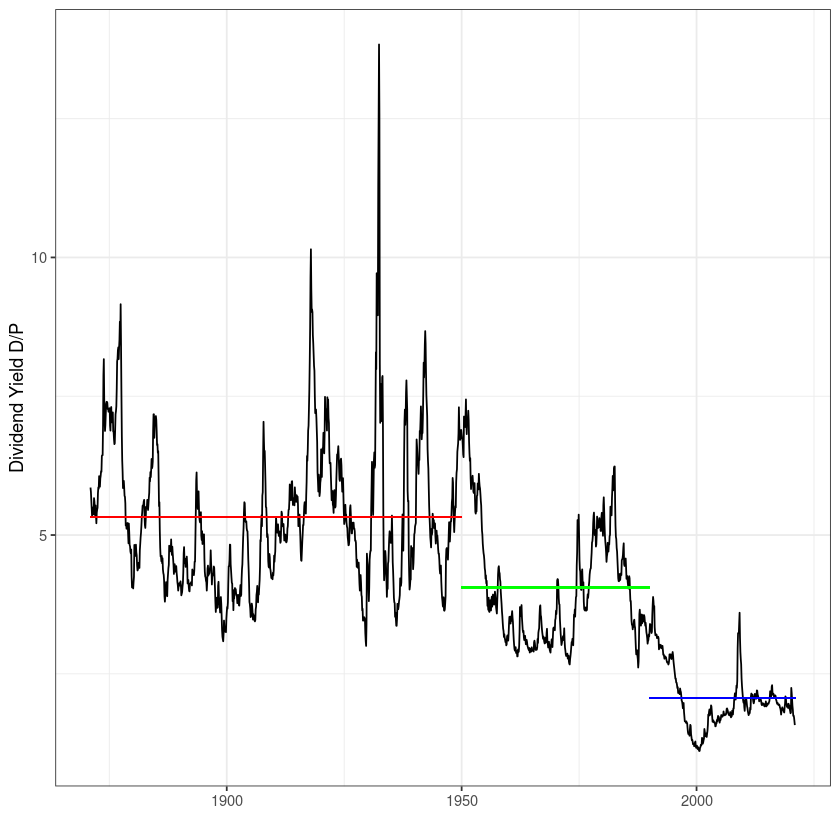

In [6]:
dividend.yield <- 100 * shiller$D / shiller$P
dividend.yield <- dividend.yield[!is.na(dividend.yield)]
mdyto1950 <- mean(window(dividend.yield,end="1950-01-01"),na.rm=TRUE)
mdy1950to1990 <- mean(window(dividend.yield,start="1950-01-01",end="1990-01-01"),na.rm=TRUE)
mdy1990topresent <- mean(window(dividend.yield,start="1990-01-01"),na.rm=TRUE)
autoplot(dividend.yield) +
  geom_segment(aes(x=start(shiller),xend=as.Date("1950-01-01"),y=mdyto1950,yend=mdyto1950),col="red") +
  geom_segment(aes(x=as.Date("1950-01-01"),xend=as.Date("1990-01-01"),y=mdy1950to1990,yend=mdy1950to1990),col="green") +
  geom_segment(aes(x=as.Date("1990-01-01"),xend=end(shiller),y=mdy1990topresent,yend=mdy1990topresent),col="blue") +
  xlab("") + ylab("Dividend Yield D/P") +
  theme_bw()